# DMQC Report: WMO 4902636

## Current Status and Metadata

- Deep ARVOR float deployed November 2023 in North Pacific, still active, on cycle 95
- Trial float using text files generated by Henry Bittig to determine DOXY adjustment for DMQC

In [1]:
import sys
# travel laptop hacky solution for importing bgcArgoDMQC locally (i.e. changes immediately imported)
sys.path.append('\\Users\\GordonC\\Documents\\projects\\bgcArgoDMQC\\')

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd

import bgcArgoDMQC as bgc

wmo = 4902636 # wmo number
# read in DMQC information from Henry Bittig
fn = f'/Users/GordonC/Documents/projects/meds-dmqc/bittig/{wmo}_IOW_Argo_inairfit_summary.txt'
meta, data, flag = bgc.io.read_bittig_textfile(fn)

# flag is the **EXPERIMENTAL** decision made by Henry's program.
# consider user choice here depending on flag/aic/etc. 
adjustment = data.loc[flag]

# HISTORY_ parameters (some set automatically on export)
history = {
    'INSTITUTION':'BI',
    'STEP':'ARSQ',
    'ACTION':'O2QC'
}

# read user config
config = bgc.configure.read_config()
comment = f'Adjusted by {config['operator']} ({config['affiliation']}, {config['orcid']}) using output provided by Henry Bittig {adjustment.comment}'

# SCIENCE_CALIB fields
sci_calib = {
    'COMMENT':comment,
    'EQUATION':meta['equation'],
    'COEFFICIENT':adjustment['coefficient']
}

# see final comment, double check length so it fits in nc dimension STRING256
print(len(comment), comment)



PLEASE USE BINFLAG 0 for float 4902636 according to rule 5.
Binflags that were within possible error interval: 0  2  4  6 with AICc: 26.8954      29.4077      28.1352      30.7382

193 Adjusted by Christopher Gordon (DFO, 0000-0002-1756-422X) using output provided by Henry Bittig after Bittig et al. (2018) eq. 21 without carry-over slope; float in-air data vs. ERA5 reanalysis


In [2]:
meta

{'WMO': '4902636',
 'inairextractiondate': '10-Dec-2025 14:39:21',
 'profilelastdate': '08-Dec-2025 13:32:00',
 'reanalysisextractiondate': '10-Dec-2025 14:41:34',
 'reanalysislastdate': '08-Dec-2025 13:32:00',
 'reanalysisstr': 'ERA5',
 'equation': 'DOXY_ADJUSTED=f(PPOX_DOXY_ADJUSTED); PPOX_DOXY_ADJUSTED=(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365)+INCLINE_T*TEMP)*(PPOX_DOXY+OFFSET); PPOX_DOXY=f(DOXY);'}

In [6]:
data

,AIC,coefficient,OFFSET,SLOPE,DRIFT,INCLINE_T,launch_date_juld,comment
binflag,,,,,,,,
0,26.8954,"OFFSET=0, SLOPE=1.0721, DRIFT=0.000, INCLINE_T...",0.0,1.0721,0.000,0.000000,20230711165600\n,after Bittig et al. (2018) eq. 21 without carr...
1,35.0095,"OFFSET=0, SLOPE=1.0728, DRIFT=0.000, INCLINE_T...",0.0,1.0728,0.000,0.000000,20230711165600\n,after Bittig et al. (2018) eq. 21; float in-ai...
2,29.4077,"OFFSET=0, SLOPE=1.0795, DRIFT=0.000, INCLINE_T...",0.0,1.0795,0.000,-0.000854,20230711165600\n,after Bittig et al. (2018) eq. 23 without carr...
3,37.2375,"OFFSET=0, SLOPE=1.0737, DRIFT=0.000, INCLINE_T...",0.0,1.0737,0.000,-0.000110,20230711165600\n,after Bittig et al. (2018) eq. 23; float in-ai...
4,28.1352,"OFFSET=0, SLOPE=1.0696, DRIFT=0.180, INCLINE_T...",0.0,1.0696,0.180,0.000000,20230711165600\n,after Bittig et al. (2018) eq. 21 without carr...
5,36.3051,"OFFSET=0, SLOPE=1.0685, DRIFT=0.308, INCLINE_T...",0.0,1.0685,0.308,0.000000,20230711165600\n,after Bittig et al. (2018) eq. 21; float in-ai...
6,30.7382,"OFFSET=0, SLOPE=1.0766, DRIFT=0.382, INCLINE_T...",0.0,1.0766,0.382,-0.001139,20230711165600\n,after Bittig et al. (2018) eq. 23 without carr...
7,38.7362,"OFFSET=0, SLOPE=1.0713, DRIFT=0.375, INCLINE_T...",0.0,1.0713,0.375,-0.000446,20230711165600\n,after Bittig et al. (2018) eq. 23; float in-ai...


In [3]:

for fn in Path(f'/Users/GordonC/Documents/data/Argo/dac/meds/{wmo}/profiles/').glob('BR*.nc'):
    prof = bgc.prof(file=fn)
    core = bgc.prof(file=fn.as_posix().replace('BR', 'R'))

    # launch date to Argo epoch JULD
    datestr = adjustment.launch_date_juld
    launch_date_juld = bgc.unit.datestr_to_juld(datestr)

    # PPOX adjusted according to meta[equation]
    ppox_doxy_adjusted = (adjustment.SLOPE*\
        (1 + adjustment.DRIFT/100*(prof.df.JULD.reset_index(drop=True) - launch_date_juld)/365) + \
        adjustment.INCLINE_T*prof.TEMP_DOXY)*(prof.PPOX_DOXY + adjustment.OFFSET)

    # add PSAL to bgc file on its pressure grid
    prof.interp(core.PSAL, core.PRES, 'PSAL', method='nearest'), # adjusted if available, this float core in R mode

    # pO2 to umol L-1 (SCOR WG 142 code)
    doxy_adjusted_umol_L = bgc.unit.pO2_to_doxy(
        ppox_doxy_adjusted,
        prof.PSAL, # adjusted if available
        prof.TEMP_DOXY, # could be core TEMP as with PSAL
        prof.PRES
    )

    # umol L-1 to umol kg-1 (density calculation)
    doxy_adjusted = bgc.unit.umol_per_L_to_umol_per_sw(
        doxy_adjusted_umol_L,
        prof.PSAL, # adjusted if available
        prof.TEMP_DOXY, # could be core TEMP as with PSAL
        prof.PRES,
        lat=prof.df.LATITUDE.reset_index(drop=True),
        lon=prof.df.LONGITUDE.reset_index(drop=True)
    )

    # update fields
    prof.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(prof.PSAL, prof.TEMP_DOXY, prof.PRES, fix_err=6))
    prof.update_field('PPOX_DOXY_ADJUSTED', ppox_doxy_adjusted)
    prof.update_field('DOXY_ADJUSTED', doxy_adjusted)
    prof.update_field('DOXY_ADJUSTED_QC', 1)
    prof.update_field('DOXY_ADJUSTED_QC', 4, where=prof.DOXY_QC == 4)
    prof.set_fillvalue('DOXY_ADJUSTED', where=prof.DOXY_ADJUSTED_QC == 4)
    prof.set_fillvalue('DOXY_ADJUSTED_ERROR', where=prof.DOXY_ADJUSTED_QC == 4)
    # export d-mode file
    prof.update_file(history, data_mode='D', sci_calib=sci_calib)


Working on file BD4902636_001.nc...done
Working on file BD4902636_002.nc...done
Working on file BD4902636_003.nc...done
Working on file BD4902636_004.nc...done
Working on file BD4902636_005.nc...done
Working on file BD4902636_006.nc...done
Working on file BD4902636_007.nc...done
Working on file BD4902636_008.nc...done
Working on file BD4902636_009.nc...done
Working on file BD4902636_010.nc...done
Working on file BD4902636_011.nc...done
Working on file BD4902636_012.nc...done
Working on file BD4902636_013.nc...done
Working on file BD4902636_014.nc...done
Working on file BD4902636_015.nc...done
Working on file BD4902636_016.nc...done
Working on file BD4902636_017.nc...done
Working on file BD4902636_018.nc...done
Working on file BD4902636_019.nc...done
Working on file BD4902636_020.nc...done
Working on file BD4902636_021.nc...done
Working on file BD4902636_022.nc...done
Working on file BD4902636_023.nc...done
Working on file BD4902636_024.nc...done
Working on file BD4902636_025.nc...done


In [4]:
prof._changelog

['DOXY_ADJUSTED_ERROR',
 'PPOX_DOXY_ADJUSTED',
 'DOXY_ADJUSTED',
 'DOXY_ADJUSTED_QC',
 'DOXY_ADJUSTED_QC',
 'DOXY_ADJUSTED']

Ok... D-mode files generated! Let's see if it looks any good...

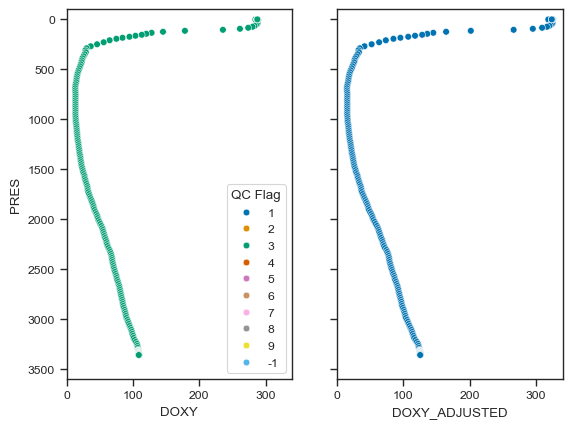

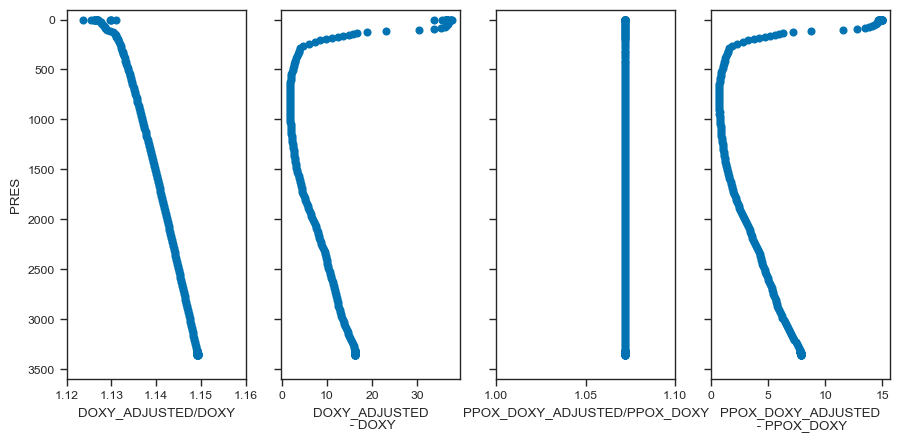

In [12]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

prof = bgc.prof(file=f'/Users/GordonC/Documents/data/Argo/dac/meds/D/{wmo}/profiles/BD{wmo}_033.nc')
prof.reset()

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
sns.scatterplot(data=prof.df, x='DOXY', y='PRES', hue='DOXY_QC', hue_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, -1], palette='colorblind', ax=axes[0])
sns.scatterplot(data=prof.df, x='DOXY_ADJUSTED', y='PRES', hue='DOXY_ADJUSTED_QC', hue_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, -1], palette='colorblind', ax=axes[1], legend=False)
axes[0].set_xlim((0, 340))
axes[0].legend(title='QC Flag')
axes[0].set_ylim((3600, -100))

fig, axes = plt.subplots(1, 4, sharex=False, sharey=True)
axes[0].plot(prof.df.DOXY_ADJUSTED/prof.df.DOXY, prof.df.PRES, 'o')
axes[1].plot(prof.df.DOXY_ADJUSTED - prof.df.DOXY, prof.df.PRES, 'o')
axes[2].plot(prof.df.PPOX_DOXY_ADJUSTED/prof.df.PPOX_DOXY, prof.df.PRES, 'o')
axes[3].plot(prof.df.PPOX_DOXY_ADJUSTED - prof.df.PPOX_DOXY, prof.df.PRES, 'o')
axes[0].set_xlim((1.12, 1.16))
axes[2].set_xlim((1.0, 1.10))
axes[0].set_ylim((3600, -100))
axes[0].set_xlabel('DOXY_ADJUSTED/DOXY')
axes[1].set_xlabel('DOXY_ADJUSTED\n - DOXY')
axes[2].set_xlabel('PPOX_DOXY_ADJUSTED/PPOX_DOXY')
axes[3].set_xlabel('PPOX_DOXY_ADJUSTED\n - PPOX_DOXY')
axes[0].set_ylabel('PRES')
fig.set_size_inches(1.66*fig.get_figwidth(), fig.get_figheight())